# Main notebook for the simulator

## Notes
- Right now focusing on linear road, using only an excerpt of tuples, and considering only position reports (tuples with type=0). The file has been created with
  - `head -n 100000 input.txt | grep -e "^0," > ../../../aggregate_modeling/data/input_stream_lr.csv`

Python related commands:
 - `conda create --name aggregate_modeling python=3.12 -y`
 - `conda activate aggregate_modeling`
 - `install ipykernel`

## Input parameters

In [ ]:
# input_file = '../data/input_stream_lr.csv' 
# mst_input_stream_file = '../data/MST_input_stream_lr.csv'
# mst_output_stream_file = '../data/MST_output_stream_lr.csv'
# mee_events_file = '../data/MEE_events_lr.csv'
# input_event_mapping =  '../data/input_event_lr.csv'
# event_output_mapping =  '../data/event_output_lr.csv'
# WA = 200 * 1000
# WS = 600 * 1000

# throughput_csv = '../data/throughput.csv'
# throughput_fig = '../data/throughput.Pdf'
# throughput_lambda = lambda x: x  # Leave throughput as is

# outputrate_csv = '../data/outputrate.csv'
# outputrate_fig = '../data/outputrate.pdf'
# outputrate_lambda = lambda x: x  # Leave output rate as is

# latency_csv = '../data/latency.csv'
# latency_fig = '../data/latency.pdf'
# latency_lambda = lambda x: x/1000  # Latency in seconds

# cpu_csv = '../data/cpu.csv'
# cpu_fig = '../data/cpu.pdf'
# cpu_lambda = lambda x: x/1000  # Fraction of second

# memory_csv = '../data/memory.csv'
# memory_fig = '../data/memory.pdf'
# memory_lambda = lambda x: x  # Leave memory as is

# # Set to true if you also want to write input/event and event/output mappings. Mostly for debugging
# write_mappings = True

# extract_time = lambda line: int(line.split(",")[1])*1000  # Extracts second value as integer time, that's the format for LR tuples, multiplies by 1000 to get ms
# extract_key = lambda line: line.split(",")[2].strip()  # Extracts third value as key, the vehicle id

In [ ]:

input_file = '../data/tests/input.csv' 

base_folder = '../data/tests/simulator/'
mst_input_stream_file = base_folder + 'MST_input_stream.csv'
mst_watermark_stream = base_folder + 'MST_watermarks_stream.csv'
mst_output_stream_file = base_folder + 'MST_output_stream.csv'
mee_events_file = base_folder + 'MEE_events.csv'
input_event_mapping =  base_folder + 'input_event.csv'
event_output_mapping =  base_folder + 'event_output.csv'
WA = 5 * 1000
WS = 10 * 1000

throughput_csv = base_folder + 'throughput.csv'
throughput_fig = base_folder + 'throughput.Pdf'
throughput_lambda = lambda x: x  # Leave throughput as is

outputrate_csv = base_folder + 'outputrate.csv'
outputrate_fig = base_folder + 'outputrate.pdf'
outputrate_lambda = lambda x: x  # Leave output rate as is

latency_csv = base_folder + 'latency.csv'
latency_fig = base_folder + 'latency.pdf'
latency_lambda = lambda x: x/1000  # Latency in seconds

cpu_csv = base_folder + 'cpu.csv'
cpu_fig = base_folder + 'cpu.pdf'
cpu_lambda = lambda x: x/1000  # Fraction of second

memory_csv = base_folder + 'memory.csv'
memory_fig = base_folder + 'memory.pdf'
memory_lambda = lambda x: x  # Leave memory as is

# Set to true if you also want to write input/event and event/output mappings. Mostly for debugging
write_mappings = True

extract_time = lambda line: int(line.split(",")[0])  # Extracts millisecond value as integer time
extract_key = lambda line: line.split(",")[1].strip()  # Extracts second value as key

In [2]:
import random

CREATE_duration = lambda: random.uniform(0.0001, 0.0002) # Assuming milliseconds
UPDATE_duration = lambda: random.uniform(0.0001, 0.0002) # Assuming milliseconds
OUTPUT_duration = lambda: random.uniform(0.0001, 0.0002) # Assuming milliseconds
DELETE_duration = lambda: random.uniform(0.0001, 0.0002) # Assuming milliseconds


CREATE_memoryDelta = lambda: random.randint(10, 10) # Assuming bytes
UPDATE_memoryDelta = lambda: random.randint(100, 120) # Assuming bytes

# The following are the main classes / utily functions / simulator code. Should not be modified

In [3]:
# Imports
import csv
from enum import Enum
import sys
from tqdm import tqdm  # Import tqdm for progress bar
import bisect
import pandas as pd
import matplotlib.pyplot as plt
import os
import math

In [ ]:
# Model Stream Tuple
class MST:
    def __init__(self, id, omega, tau, w, k):
        self.id = id # The unique ID
        self.omega = omega # The wallclock time
        self.tau = tau # The event time
        self.w = w # Boolean specifying whether this is a watermark or a regular tuple
        self.k = k # The associated key

    def to_list(self):
        """Convert the object to a list for CSV writing."""
        return [self.id, self.omega, self.tau, self.w, self.k]

# Window Action
class WinAction (Enum):  
    CREATE = 1
    UPDATE = 2
    OUTPUT = 3
    DELETE = 4

# Model Execution Event
class MEE:
    def __init__(self, id, omega, tau, winAction, k, duration, memoryDelta):
        self.id = id # The unique ID
        self.omega = omega # The wallclock time
        self.tau = tau # The event time
        self.winAction = winAction # Action 
        self.k = k # The associated key
        self.duration = duration # The time it takes to perform the action
        self.memoryDelta = memoryDelta # The change in memory consumption

    def to_list(self):
        """Convert the object to a list for CSV writing."""
        return [self.id, self.omega, self.tau, self.winAction, self.k, self.duration, self.memoryDelta]
    
def get_sliding_window_starts(tau, WA, WS):
    """
    Returns a list of all starting times of sliding windows that contain tau.
    
    :param tau: The event time
    :param WA: The window advance (step size)
    :param WS: The window size
    :return: A list of start times of windows containing tau
    """
    start_times = []
    latest_start = math.floor(tau/WA)*WA  # Latest possible window start containing tau
    start_times.append(latest_start)

    while tau < latest_start-WA+WS:
        latest_start = latest_start - WA
        start_times.append(latest_start)
        
    return sorted(start_times)

def aggregate_to_csv(
    input_csv,
    time_column,
    agg_function,
    output_csv,
    value_column=None,
    fill_value=None,        # Value to use for time entries that have no aggregate valuer
    transform_fn=None       # Optional lambda function to modify values before writing
):
    """Aggregates data over time and writes the results to a CSV file."""
    
    if not os.path.isfile(input_csv):
        raise FileNotFoundError(f"The file '{input_csv}' does not exist.")

    df = pd.read_csv(input_csv)

    if time_column not in df.columns:
        raise ValueError(f"Time column '{time_column}' not found in CSV file.")
    if agg_function in ["sum", "average"] and (value_column is None or value_column not in df.columns):
        raise ValueError(f"Value column '{value_column}' is required for aggregation function '{agg_function}'.")

    df[time_column] = df[time_column] // 1000  # Convert ms to seconds

    if agg_function == "count":
        aggregated_df = df.groupby(time_column).size().reset_index(name="value")
    elif agg_function == "sum":
        aggregated_df = df.groupby(time_column)[value_column].sum().reset_index(name="value")
    elif agg_function == "average":
        aggregated_df = df.groupby(time_column)[value_column].mean().reset_index(name="value")
    elif agg_function == "cumsum":
        aggregated_df = df.groupby(time_column)[value_column].sum().cumsum().reset_index(name="value")
    else:
        raise ValueError("Invalid aggregation function. Use 'count', 'sum', or 'average'.")

    # Fill missing seconds with the specified fill_value
    full_range = pd.DataFrame({time_column: range(df[time_column].min(), df[time_column].max() + 1)})
    aggregated_df = full_range.merge(aggregated_df, on=time_column, how="left").fillna(fill_value)

    # Apply optional transformation function
    if transform_fn:
        aggregated_df["value"] = aggregated_df["value"].apply(transform_fn)

    # Write to CSV
    aggregated_df.to_csv(output_csv, index=False)
    print(f"Aggregated data saved to {output_csv}")


def plot_from_csv(input_csv, output_plot_file="output_plot.png"):
    """Reads aggregated data from a CSV and generates a plot."""
    
    df = pd.read_csv(input_csv)
    
    plt.figure(figsize=(10, 5))
    plt.plot(df.iloc[:, 0], df.iloc[:, 1], marker='o', linestyle='-')
    plt.xlabel("Time (seconds)")
    plt.ylabel("Value")
    plt.title("Aggregated Data Over Time")
    plt.grid()
    plt.show()

    plt.savefig(output_plot_file)
    plt.close()
    print(f"Plot saved to {output_plot_file}")

In [ ]:
def process_stream(input_file, mst_input_stream, mst_watermark_stream, extract_time, extract_key):
    counter = 0
    last_tau = None
    non_decreasing = True

    with open(input_file, 'r') as infile, open(mst_input_stream, 'w', newline='') as outfile_tuples, open(mst_watermark_stream, 'w', newline='') as outfile_watermarks:
        writer_tuples = csv.writer(outfile_tuples)
        writer_tuples.writerow(["id", "omega", "tau", "w", "k"])  # CSV header
        writer_watermarks = csv.writer(outfile_watermarks)
        writer_watermarks.writerow(["id", "omega", "tau", "w", "k"])  # CSV header

        for line in infile:
            tau = extract_time(line)  # Extract event time
            k = extract_key(line)  # Extract key

            # Check if tau decreased
            if last_tau is not None and tau < last_tau:
                non_decreasing = False

            # If tau increased, insert a watermark tuple before the new tau
            if last_tau is not None and tau > last_tau:
                watermark = MST(counter, last_tau, last_tau, True, None)
                writer_watermarks.writerow(watermark.to_list())
                counter += 1

            # Create regular tuple
            mst = MST(counter, tau, tau, False, k)
            writer_tuples.writerow(mst.to_list())
            counter += 1

            last_tau = tau

        # At the end, a final watermark that flushes everything
        watermark = MST(counter, last_tau, sys.maxsize, True, None)
        writer_tuples.writerow(watermark.to_list())

    return non_decreasing

In [ ]:
non_decreasing = process_stream(input_file, mst_input_stream_file, mst_watermark_stream, extract_time, extract_key)

if non_decreasing:
    print('Tuples had non-decreasing event times, so mst_input_stream_file can be used as is')
else:
    print('Tuples had decreasing event times, so mst_input_stream_file should be adjusted to have consistent watermarks')


Tuples had non-decreasing event times, so mst_input_stream_lr.csv can be used as is


In [ ]:
def process_mst_stream(
    mst_input_stream_file,  # Input CSV for MST input tuples
    mee_events_file,  # Output CSV for MEE events
    input_event_mapping,  # Output CSV for input-event mappings
    mst_output_stream_file, # Input CSV for MST output tuples
    event_output_mapping, # Output CSV for event-output mappings
    WA,  # Window advance (step size)
    WS
):
    
    wins = {} # dictionary keeping track of the open windows
    pendingMEEs = [] # Buffer of temporary events that are waiting for a watermark to be triggered
    event_counter = 0 # counter used as id of the MEE events
    output_counter = 0 # counter used as id of MST output tuples
    accumulated_execution_time = 0.0 # used to keep track of actual execution time of each window action/output tuple
    
    with open(mst_input_stream_file, 'r') as infile, \
            open(mee_events_file, 'w', newline='') as out_mee, \
            open(input_event_mapping, 'w', newline='') as out_event_map, \
            open(mst_output_stream_file, 'w', newline='') as output, \
            open(event_output_mapping, 'w', newline='') as event_output:
        
        mst_reader = csv.reader(infile)
        next(mst_reader)  # Skip header

        # This part is to show a progress bar
        total_rows = sum(1 for _ in infile)  # Count total rows
        infile.seek(0)  # Reset file pointer
        next(mst_reader)  # Skip header again
        
        mee_writer = csv.writer(out_mee)
        event_map_writer = csv.writer(out_event_map)
        output_writer = csv.writer(output)
        event_output_writer = csv.writer(event_output)
        
        mee_writer.writerow(["i", "omega", "tau", "winAction", "k", "duration","memoryDelta"])
        event_map_writer.writerow(["input_id", "event_id"])
        output_writer.writerow(["i", "omega", "tau", "w", "k", "l"])
        event_output_writer.writerow(["event_id", "output_id"])
        
        for row in tqdm(mst_reader, total=total_rows, desc="Processing Rows", unit="row"):
            i, omega, tau, w, k = int(row[0]), int(row[1]), int(row[2]), row[3] == 'True', row[4] if row[4] != 'None' else None
        
            if not w:  # Regular tuple

                # Adjust the accumulated time
                accumulated_execution_time = max(omega, accumulated_execution_time)

                for start_time in get_sliding_window_starts(tau, WA, WS):
                    if (start_time, k) not in wins:
                        # output the event
                        create_duration = CREATE_duration()
                        create_memoryDelta = CREATE_memoryDelta()
                        mee_writer.writerow([event_counter, int(accumulated_execution_time), start_time, WinAction.CREATE.name, k, create_duration, create_memoryDelta])
                        if write_mappings:
                            event_map_writer.writerow([i, event_counter])
                        # Keep track of time passing
                        accumulated_execution_time += create_duration
                        # Remember there's an output (and a delete action to take care of later on)
                        # Compute the key (start_time) for all existing elements
                        insert_item = [None, None, start_time, WinAction.OUTPUT.name, k, 0, 0]
                        insert_key = insert_item[2]
                        # Extract the list of start_times to use for comparison
                        keys = [item[2] for item in pendingMEEs]
                        index = bisect.bisect_right(keys, insert_key)
                        pendingMEEs.insert(index, insert_item)
                        
                        event_counter += 1
                        # Keep track of the created window
                        wins[(start_time, k)] = create_memoryDelta
                    
                    update_duration = UPDATE_duration()
                    update_memoryDelta = UPDATE_memoryDelta()
                    mee_writer.writerow([event_counter, int(accumulated_execution_time), start_time, WinAction.UPDATE.name, k, update_duration, update_memoryDelta])
                    if write_mappings:
                        event_map_writer.writerow([i, event_counter])
                    event_counter += 1
                    
                    # Keep track of increased memory usage for the window
                    wins[(start_time, k)] = wins.get((start_time, k)) + update_memoryDelta
                    
                    # Keep track of time passing
                    accumulated_execution_time += update_duration
                    
            else:  # Watermark
                while pendingMEEs and pendingMEEs[0][2] + WS <= tau: # Notice here we need to check based on the event time of the corresponding output tuple
                    
                    # pop the output event and adjust times
                    x = pendingMEEs.pop(0)
                    x[0] = event_counter
                    x[1] = int(accumulated_execution_time)
                    win_left_boundary = x[2]
                    k = x[4]
                    
                    output_duration = OUTPUT_duration()
                    x[5] = output_duration
                    x[6] = 0
                    
                    # Write the output event
                    mee_writer.writerow(x)
                    if write_mappings:
                        event_map_writer.writerow([i, event_counter])
                    
                    # Adjust accumulated time
                    accumulated_execution_time += output_duration

                    # Write output
                    output_writer.writerow([output_counter, int(accumulated_execution_time), win_left_boundary + WS - 1, False, k, int(accumulated_execution_time)-omega])
                    if write_mappings:
                        event_output_writer.writerow([event_counter, output_counter])
                    
                    # Now write the deletion event
                    delete_duration = DELETE_duration()
                    mee_writer.writerow([event_counter+1, int(accumulated_execution_time), win_left_boundary, WinAction.DELETE.name, x[4], delete_duration, -1 * wins.get((win_left_boundary, k))])
                    if write_mappings:
                        event_map_writer.writerow([i, event_counter+1])
                    
                    event_counter += 2
                    output_counter += 1

                    # Update accumulated time
                    accumulated_execution_time += delete_duration
                    
                    # Remove window
                    wins.pop((win_left_boundary, k), None)
                    

process_mst_stream(mst_input_stream_file, mee_events_file, input_event_mapping, mst_output_stream_file, event_output_mapping, WA, WS)

Processing Rows:   0%|          | 0/58315 [00:00<?, ?row/s]

Processing Rows: 100%|██████████| 58315/58315 [00:01<00:00, 47208.97row/s]


Aggregated data saved to ../data/tests/simulator/throughput.csv


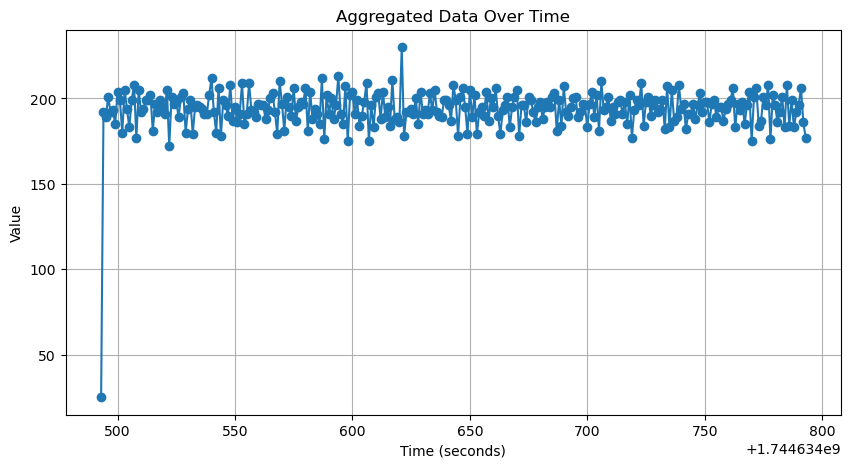

Plot saved to ../data/tests/simulator/throughput.Pdf
Aggregated data saved to ../data/tests/simulator/outputrate.csv


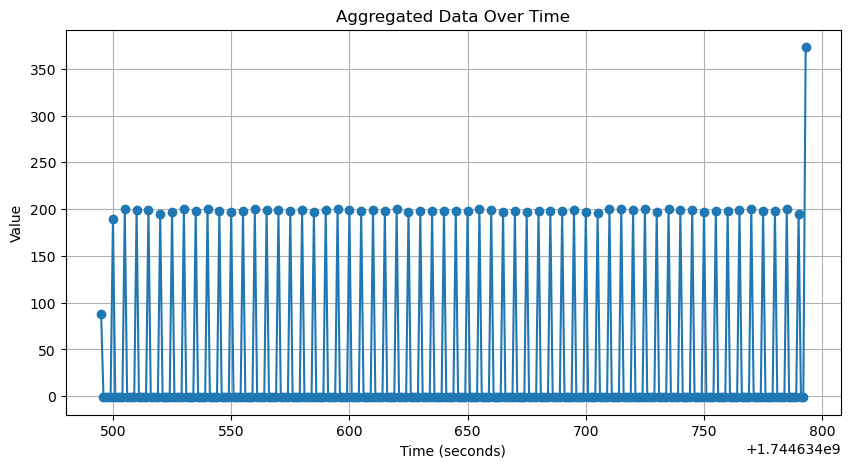

Plot saved to ../data/tests/simulator/outputrate.pdf
Aggregated data saved to ../data/tests/simulator/latency.csv


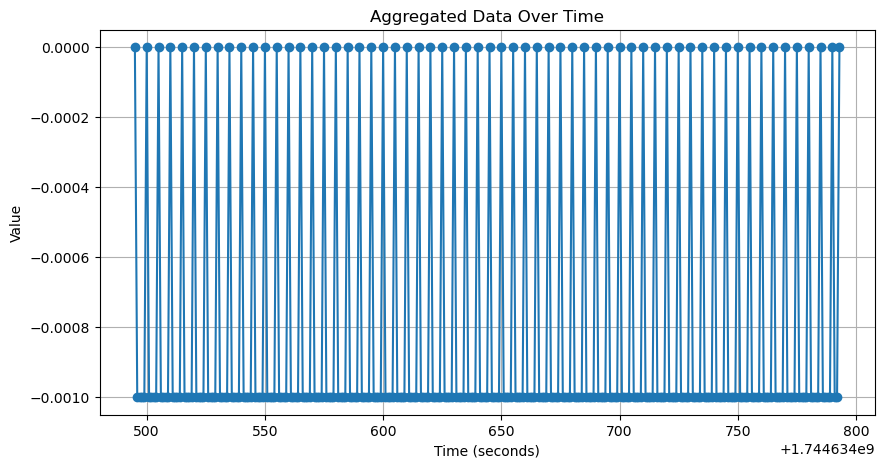

Plot saved to ../data/tests/simulator/latency.pdf
Aggregated data saved to ../data/tests/simulator/cpu.csv


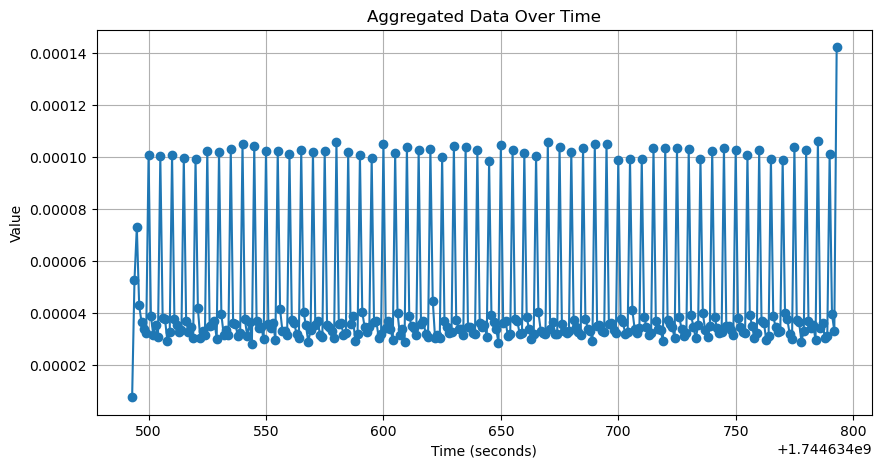

Plot saved to ../data/tests/simulator/cpu.pdf
Aggregated data saved to ../data/tests/simulator/memory.csv


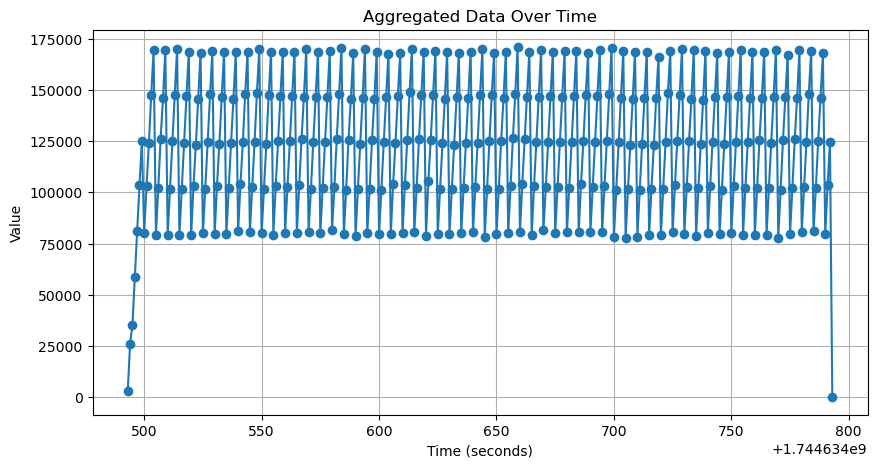

Plot saved to ../data/tests/simulator/memory.pdf


In [8]:
aggregate_to_csv(mst_input_stream_file, "omega", "count", throughput_csv, value_column=None, fill_value=-1, transform_fn=throughput_lambda)
plot_from_csv(throughput_csv, throughput_fig)
aggregate_to_csv(mst_output_stream_file, "omega", "count", outputrate_csv, value_column=None, fill_value=-1, transform_fn=outputrate_lambda)
plot_from_csv(outputrate_csv, outputrate_fig)
aggregate_to_csv(mst_output_stream_file, "omega", "average", latency_csv, value_column="l", fill_value=-1, transform_fn=latency_lambda)
plot_from_csv(latency_csv, latency_fig)
aggregate_to_csv(mee_events_file, "omega", "sum", cpu_csv, value_column="duration", fill_value=-1, transform_fn=cpu_lambda)
plot_from_csv(cpu_csv, cpu_fig)
aggregate_to_csv(mee_events_file, "omega", "cumsum", memory_csv, value_column="memoryDelta", fill_value=-1, transform_fn=memory_lambda)
plot_from_csv(memory_csv, memory_fig)


# Comments on the experiments 

## 25/03/10
- Seems correct, but also extremely slow. Around 45 rows/second (or tuples/second)
  - get_sliding_window_starts was the problem. Need to check again, but should be correct now
- Of course one of the fundamental things is to show that the simulator is significantly faster then the actual aggregate
- Made the writing of input/event and event/output mapping optional (no visible speed change, though)
- Right now the output stream of MST does not contain watermarks, consider adding that?
- the statistics need to be fixed, for instance with None when values are not defined
- Also, for the statistics
  - CPU consumption is a different thing, needs more data preparation
  - Memory too, we need estimators of how much each tuple adds to the window
- For the Aggregate, we could have an Aggregate with sampling features that can be used to profile a bit the expected execution